In [1]:
import pandas as pd 
import numpy as np
from typing import List, Optional
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models_data):
    """
    Plots ROC curves for multiple models.

    Parameters:
    - models_data: Dictionary where keys are model names and values are a tuple containing true labels and predicted probabilities.
    """
    
    plt.figure(figsize=(10, 8))

    # Plot the "No Skill" line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guess')

    # Plot ROC curves for each model
    for model_name, data in models_data.items():
        y_true, predicted_probabilities = data
        fpr, tpr, _ = roc_curve(y_true, predicted_probabilities)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



### read our model results

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
tqdm.pandas()
import torch
from torch import nn
from torch.nn import Transformer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import average_precision_score


In [4]:

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = [torch.tensor(seq, dtype=torch.float32) for seq in src_data]
        self.tgt_data = [torch.tensor(tgt, dtype=torch.float32) for tgt in tgt_data]

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

# Custom Collate function to handle variable sequence length
def collate_fn(batch):
    src, tgt = zip(*batch)
    src = pad_sequence(src, batch_first=True, padding_value=0)
    tgt = pad_sequence(tgt, batch_first=True, padding_value=-1)  # Special padding value for target data
    return src, tgt


def create_masks(src):
    src_key_padding_mask = (src == 0).all(axis=-1)
    
    # future_mask shape should be (seq_len, seq_len)
    future_mask = torch.triu(torch.ones((src.shape[1], src.shape[1])), diagonal=1).bool()

    return src_key_padding_mask, future_mask


# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embedding_size, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_size)
        self.transformer = Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
        )
        self.fc = nn.Linear(embedding_size, 1)

    def forward(self, src, src_key_padding_mask=None, future_mask=None):
        #print(np.shape(src))
        src = self.embedding(src)
        #print(np.shape(src))
        src = src.transpose(0, 1) 
        #print(np.shape(src))
        output = self.transformer.encoder(src, src_key_padding_mask=src_key_padding_mask, mask = future_mask)
        #print(np.shape(output))
        output = self.fc(output)
        #print(np.shape(output))
        output = torch.sigmoid(output)
        #print(np.shape(output))
        return output.transpose(0, 1).squeeze(-1)



In [5]:
# Transformer KG Model
# first KG_dims are word embedding vectors, will be put into a linear layer first to reduce the dim to KG_compress_dims
# the compressed word embedding will be concated with the other features , and go through transformers 
class TransformerKGModel(nn.Module):
    def __init__(self, KG_dims, KG_compress_dims, input_dim, embedding_size, num_heads, num_layers, dropout):
        super(TransformerKGModel, self).__init__()
        self.compress  = nn.Linear(KG_dims, KG_compress_dims)
        #self.concat_dims = KG_compress_dims
        self.embedding = nn.Linear(input_dim, embedding_size)
        self.transformer = Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
        )
        self.fc = nn.Linear(embedding_size, 1)

    def forward(self, src, src_key_padding_mask=None, future_mask=None):
        
        KG_part = src[:,:,:self.compress.in_features] # first KG_dims features are word embeddings
        
        
        other_parts = src[:,:, self.compress.in_features:] # [seq_len, batch_size, feature_size]
        # Compress KG_part  to KG_compress_dims
        compressed = self.compress(KG_part)  
        # Concatenate with second part
        src = torch.cat((compressed, other_parts), dim=-1)  
        # Reshape for transformer
   
        #src = src.unsqueeze(1)
        

        src = self.embedding(src)

        src = src.transpose(0, 1) 

        output = self.transformer.encoder(src, src_key_padding_mask=src_key_padding_mask, mask = future_mask)

        output = self.fc(output)

        output = torch.sigmoid(output)

        return output.transpose(0, 1).squeeze(-1)


In [6]:
import pickle
with open('./data/src_data_KG_0905.pkl', 'rb') as file1:
    src_data = pickle.load(file1)
    
    
with open('./data/tgt_data_KG_0905.pkl', 'rb') as file2:
    tgt_data = pickle.load(file2)
    

In [7]:
print(len(src_data), len(tgt_data))

33528 33528


In [8]:
# Split data into training and testing sets
src_train, src_test, tgt_train, tgt_test = train_test_split(src_data, tgt_data, test_size=0.2, random_state=0)

# Create datasets
train_dataset = MyDataset(src_train, tgt_train)
test_dataset = MyDataset(src_test, tgt_test)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [9]:
import torch
print(torch.__version__)
print(torch.version.cuda)

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# Now, you can use `device` to send your tensors to the GPU or CPU.


2.0.1
11.7
Using CPU


In [11]:
# KG Transformer model
KG_dims =64
KG_compress_dims = 16
input_dim = len(src_train[0][0]) -KG_dims + KG_compress_dims
embedding_size = 16*2
num_heads = 4
num_layers = 2
dropout = 0.2

model= TransformerKGModel(KG_dims, KG_compress_dims, input_dim, embedding_size, num_heads, num_layers, dropout)

# Step 2: Load the weights
model_path = "./data/memory_transformer_KG_v1_0905.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

TransformerKGModel(
  (compress): Linear(in_features=64, out_features=16, bias=True)
  (embedding): Linear(in_features=32, out_features=32, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): Tran

In [12]:
model.eval()
with torch.no_grad():
    all_probs, all_preds, all_targets = [], [],[]
    for src, tgt in test_dataloader:
        src = src.to(device)

        tgt = tgt.to(device)
        # Create masks
        src_key_padding_mask = (src == 0).all(axis=-1).to(device)

        # Pass your sequences and mask through the model
        output = model(src, src_key_padding_mask)

        # Save predictions and targets
        tgt_mask = (tgt != -1).to(device)
        probs = output[tgt_mask].cpu().numpy()
        preds = (output > 0.5).float()
        all_probs.extend(probs)
        all_preds.extend(preds[tgt_mask].cpu().numpy())
        all_targets.extend(tgt[tgt_mask].cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else np.nan
    avg_precision = average_precision_score(all_targets, all_probs)


In [13]:
len(all_targets)

4725894

In [14]:
print(f"Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}, Average Precision Score: {avg_precision}")

Accuracy: 0.792072568703403, F1 Score: 0.8583064395073848, ROC AUC: 0.838790699801552, Average Precision Score: 0.9220629361855226


### pick up the records where the word shows up at the first of a given day for each user , so that we can compare with benchmarks fairly

In [15]:
# #'Y','spelling','review_time','uid', 'user_tenure','rsp1_rate',
#        'rsp2_rate', 'rsp3_rate', 'rsp4_rate', 'acknowledge_rate', 'difficulty',  'study_method', 'repeat_time_inday',
#        'real_delta_interval_within_inday', 'review_day_th',
#        'delta_t_between_inday', 'delta_t_within_inday', 'repeat_time_history',
#        'delta_interval_within_inday','last_real_interval_byday'

In [39]:
model.eval()
with torch.no_grad():
    sub_all_probs, sub_all_preds, sub_all_targets = [], [],[]
    for src, tgt in test_dataloader:
        src = src.to(device)

        tgt = tgt.to(device)
        # Create masks
        src_key_padding_mask = (src == 0).all(axis=-1).to(device)

        # Pass your sequences and mask through the model
        output = model(src, src_key_padding_mask)

        # Save predictions and targets
        tgt_mask = (tgt != -1).to(device)
        
        # condition 1:  the -8th feature is repeat_time_inday. ==1 meaning this word shows up first time in the specific day for the user.
         # condition 2 : we exclude the word shown to customers first time in history 
        condition1 = src[...,-8]==1
        condition2 = src[...,-1]!=0
        combined_condition = condition1 & condition2
        
        indices = torch.nonzero(combined_condition)
        output =output[indices[:, 0], indices[:, 1]]
   
        probs =output.cpu().numpy()
        
        
        preds = (output > 0.5).float()
        
        sub_all_probs.extend(probs)
        sub_all_preds.extend(preds.cpu().numpy())
        sub_all_targets.extend(tgt[indices[:, 0], indices[:, 1]].cpu().numpy())



In [40]:
len(sub_all_targets)

957191

In [41]:
# Compute metrics
sub_accuracy = accuracy_score(sub_all_targets, sub_all_preds)
sub_f1 = f1_score(sub_all_targets, sub_all_preds)
sub_roc_auc = roc_auc_score(sub_all_targets, sub_all_probs) if len(np.unique(sub_all_targets)) > 1 else np.nan
sub_avg_precision = average_precision_score(sub_all_targets, sub_all_probs)


In [42]:
print(f"Accuracy: {sub_accuracy}, F1 Score: {sub_f1}, ROC AUC: {sub_roc_auc}, Average Precision Score: {sub_avg_precision}")

Accuracy: 0.7443582315337274, F1 Score: 0.8243230242819585, ROC AUC: 0.7669904946808391, Average Precision Score: 0.8778724440382282


### read benchmark models results

In [43]:
GRU_HLR_results = pd.read_csv('./data/GRU_HLR_results.csv')
HLR_results = pd.read_csv('./data/HLR_results.csv')
DHP_HLR_results = pd.read_csv('./data/DHP_HLR_results.csv')

In [44]:
len(GRU_HLR_results.y_test)

925165

## Model ROC Curves

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

def plot_roc_curve2(models_data):
    """
    Plots fancy ROC curves for multiple models.

    Parameters:
    - models_data: Dictionary where keys are model names and values are a tuple containing true labels and predicted probabilities.
    """
    
    plt.figure(figsize=(12, 10))
    sns.set_style("whitegrid")
    
    # Plot the "No Skill" line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='grey', alpha=0.7, label='Random Guess')

    # Use a colormap to get color for the plots
    colormap = plt.get_cmap('tab10')
    
    # Plot ROC curves for each model
    for idx, (model_name, data) in enumerate(models_data.items()):
        y_true, predicted_probabilities = data
        fpr, tpr, _ = roc_curve(y_true, predicted_probabilities)
        roc_auc = auc(fpr, tpr)
        color = colormap(idx)
        plt.plot(fpr, tpr, color=color, lw=2, alpha=0.8, label=model_name)
        # Annotate the AUC on the plot
        auc_x = fpr[np.argmin(np.abs(tpr - 0.5))]
        auc_y = tpr[np.argmin(np.abs(tpr - 0.5))]
        plt.annotate(f"AUC: {roc_auc:.2f}", (auc_x, auc_y), color=color, xytext=(-10,-10), textcoords='offset points')

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc='lower right', title='Models')
    plt.tight_layout()
    plt.show()


In [46]:
models_data = {
    'GRU_HLR': (GRU_HLR_results.y_test, GRU_HLR_results.y_prob.values),
        'Duolingo_HLR': (HLR_results.y_test, HLR_results.y_prob.values),
        'DHP_HLR': (DHP_HLR_results.y_test, DHP_HLR_results.y_prob.values),
    "KG_Transformer": (all_targets,all_probs),
    "KG_Transformer_first":(sub_all_targets, sub_all_probs)
}


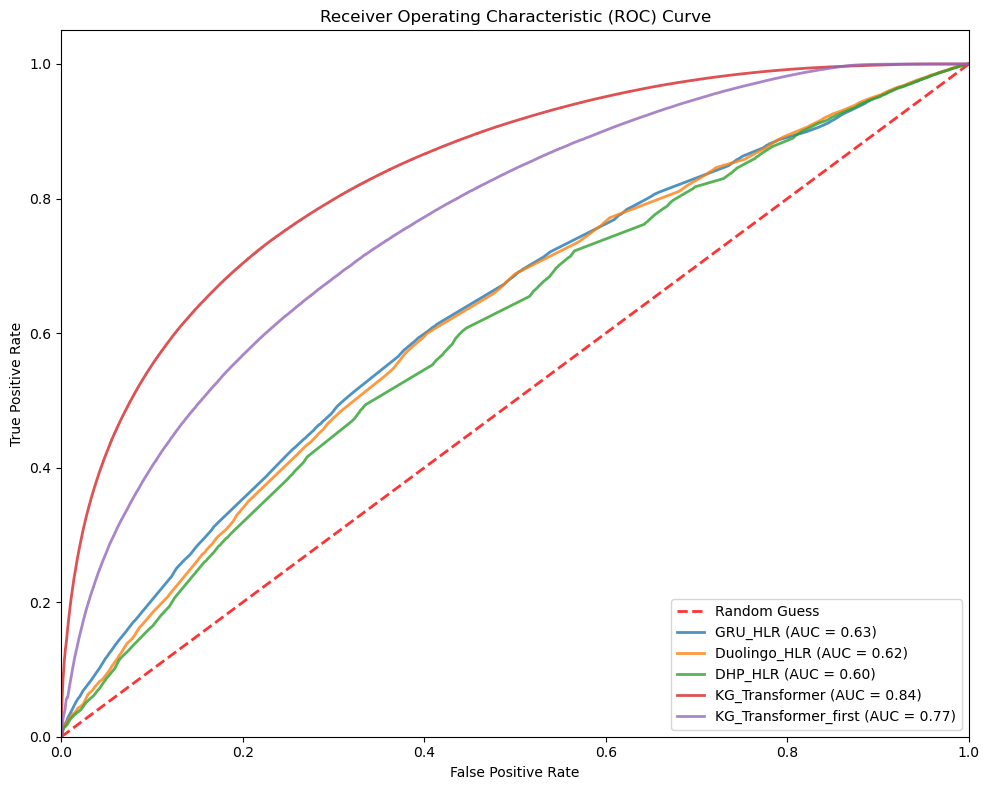

In [47]:
plot_roc_curve(models_data)

## build performance table 

In [48]:
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_auc_score, average_precision_score,hamming_loss,cohen_kappa_score,balanced_accuracy_score
l =[]
for model_name, data in models_data.items():
    print(model_name)
    y_true, predicted_probabilities = data
    predicted_probabilities = np.array(predicted_probabilities)
    y_pred_label = np.where(predicted_probabilities > 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)
    roc_auc = roc_auc_score(y_true, predicted_probabilities) if len(np.unique(y_true)) > 1 else np.nan
    avg_precision = average_precision_score(y_true, predicted_probabilities)
    Log_loss = log_loss(y_true,predicted_probabilities)
    Hamming_loss = hamming_loss(y_true, y_pred_label)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_label)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_label)
    l.append([model_name,accuracy,f1,roc_auc, avg_precision,Log_loss,Hamming_loss,cohen_kappa,balanced_accuracy])
    


GRU_HLR
Duolingo_HLR
DHP_HLR
KG_Transformer
KG_Transformer_first


In [49]:
performance_report= pd.DataFrame(l,columns = ["model_name","accuracy","f1","roc_auc", "avg_precision","Log_loss","Hamming_loss","cohen_kappa","balanced_accuracy"])
performance_report

,model_name,accuracy,f1,roc_auc,avg_precision,Log_loss,Hamming_loss,cohen_kappa,balanced_accuracy
0,GRU_HLR,0.700596,0.816889,0.628669,0.793185,0.608101,0.299404,0.071481,0.527857
1,Duolingo_HLR,0.704943,0.821376,0.621781,0.784095,0.622004,0.295057,0.064805,0.524711
2,DHP_HLR,0.704554,0.821662,0.604061,0.772706,0.599084,0.295446,0.057577,0.521815
3,KG_Transformer,0.792073,0.858306,0.838791,0.922063,0.437670,0.207927,0.469802,0.722380
4,KG_Transformer_first,0.744358,0.824323,0.766990,0.877872,0.517027,0.255642,0.356574,0.670732


In [50]:
performance_report.to_csv('./data/performance_comparison_report.csv',index=None)